In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from __future__ import division

import os

from IPython.display import display
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from sklearn.preprocessing import OneHotEncoder

from nsim.scene.noise import ArNoiseGen, ar_model_check_stable
from utils import generate_waveforms, NeuronConfig
from mgng import mgng

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.random.seed(0)
firing_rates = np.random.random(size=3)/1000
window_scales = np.random.randint(10, size=3)
neuron_params = [NeuronConfig(f, w) for f in firing_rates for w in window_scales]
neuron_nr = len(neuron_params)
channels_nr = 5
data_len = int(2e6)
window_size = 42

In [3]:
data_fname = '{}n_{}c_{}l.csv'.format(neuron_nr, channels_nr, data_len)
firings_fname = '{}n_{}c_{}l_firings.csv'.format(neuron_nr, channels_nr, data_len)

if os.path.exists(data_fname):
    data = pd.read_csv(data_fname)
    firings = pd.read_csv(firings_fname, index_col=0)
    firings.columns = ['neuron', 'fire_idx']
else:
    data, neurons = generate_waveforms(data_len=data_len, channels_nr=channels_nr,
                                       neuron_params=neuron_params, window_size=window_size)
    
    data = pd.DataFrame(data)
    data['index'] = data.index
    data.to_csv(data_fname, index=False)
    
    firings = [[i, j] for i, n in enumerate(neurons) for j in n['fire_seq']]
    firings = pd.DataFrame(firings, columns=['neuron', 'fire_idx'])
    firings.sort_values('fire_idx', inplace=True)
    firings.set_index('fire_idx', drop=False, inplace=True)
    firings.to_csv(firings_fname, index=False)

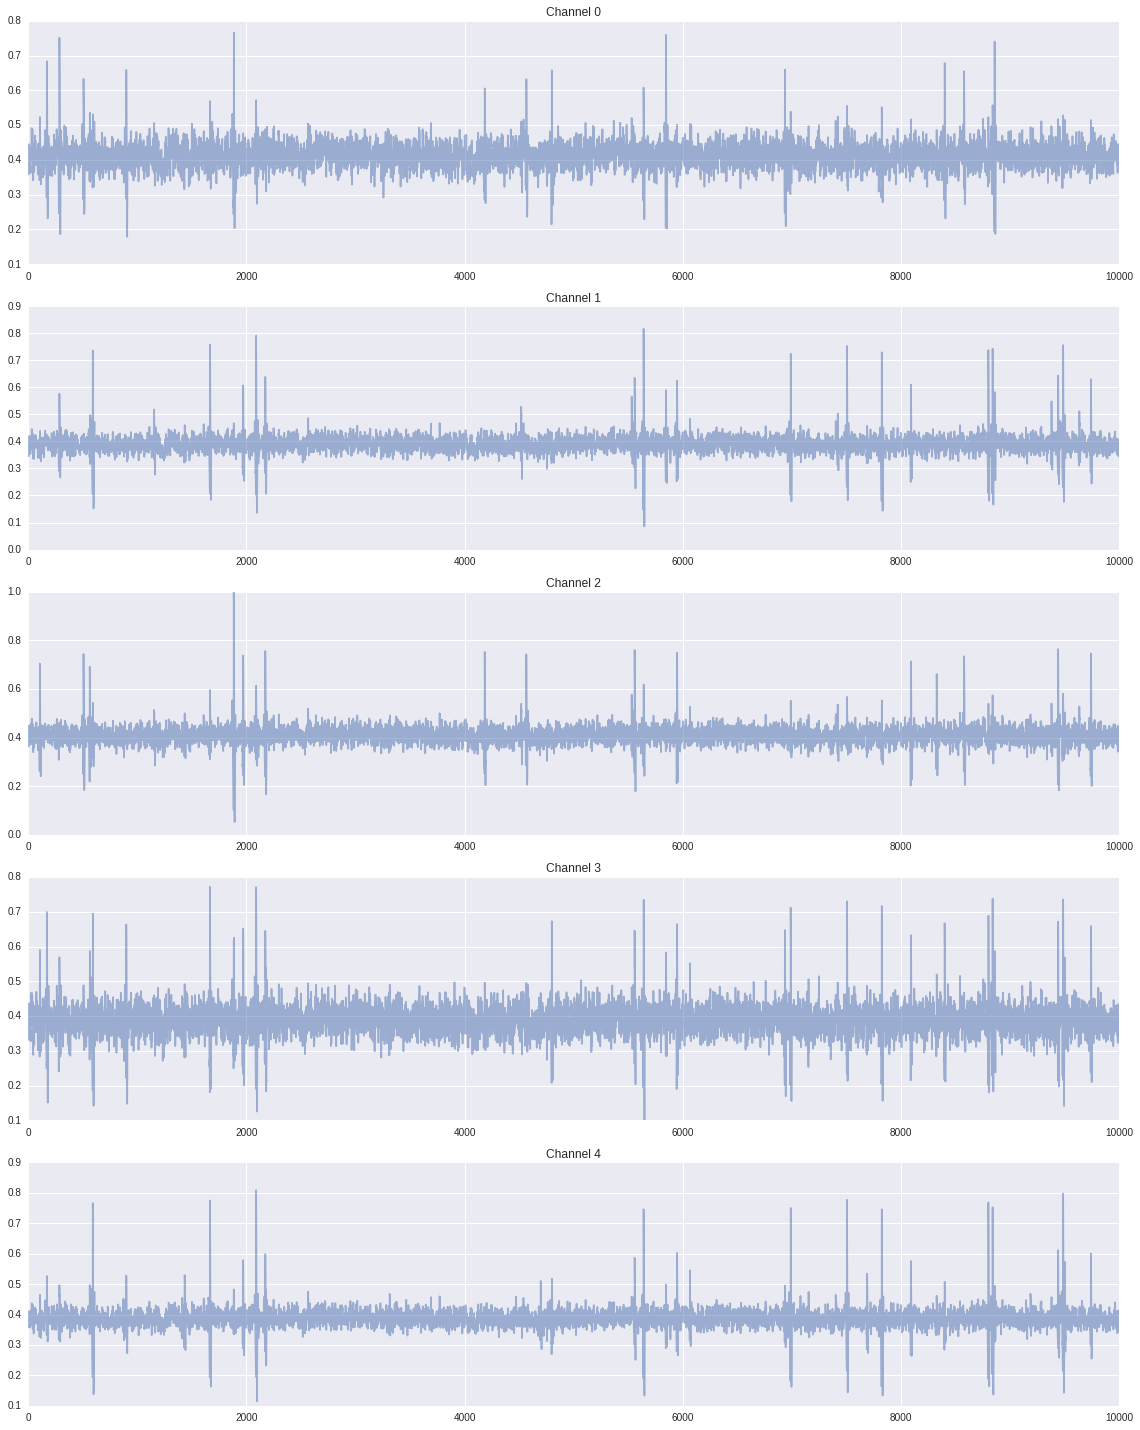

In [4]:
data = (data - data.min())/(data.max()-data.min())
f, axes = plt.subplots(channels_nr, figsize=(16, 4*channels_nr))
axes = axes.flatten()

from_idx = 0
to_idx = len(data)
marker_size = 100

cmap = sns.color_palette('Dark2', n_colors=neuron_nr)
for c in range(channels_nr):
    ax = axes[c]
    ax.set_title('Channel {}'.format(c))
    data.iloc[from_idx:to_idx, c].plot(alpha=0.5, ax=ax)
    #for _, firing in firings[(from_idx <= firings.fire_idx)& (firings.fire_idx <= to_idx)].iterrows():
    #    ax.axvspan(firing.fire_idx, firing.fire_idx + window_size,
    #               facecolor=cmap[firing.neuron], alpha=0.3)
        
f.tight_layout()

In [69]:
model_fname = 'mgng_model.pickle'
winner_units_fname = 'winner_units.pickle'
mgng_unit_nr = 30
from_idx = 0
to_idx = len(data)
#from_idx = 0
#to_idx = 20000

if os.path.exists(model_fname) and False:
    model = joblib.load(model_fname)
    winner_units = joblib.load(winner_units_fname)
else:
    model = mgng.MGNG(dimensions=channels_nr, theta=mgng_unit_nr, gamma=10000, verbose=True)


    points_nr = to_idx - from_idx

    winner_units = pd.DataFrame(np.zeros((to_idx - from_idx, channels_nr+2)),
                                columns=['index', 'w1'] +
                                        ['w1_weight_{}'.format(i)
                                         for i in range(channels_nr)])
    for i, time_point in data.iloc[from_idx:to_idx, :].iterrows():
        if i%(points_nr//10) == 0:
            print "{}% done".format(100*i//points_nr)
        xt = np.asarray(time_point.iloc[:-1])
        w1, _ = model.time_step(xt)
        winner_units.loc[i, ['index', 'w1']] = [i, w1]
        winner_units.iloc[i, 2:] = model.weights[w1]

    joblib.dump(model, model_fname, compress=3)
    joblib.dump(winner_units, winner_units_fname, compress=3);

Node 0 added.
Node 1 added.
0% done
Node 2 added.
Node 3 added.
Node 4 added.
Node 5 added.
Node 6 added.
Node 7 added.
Node 8 added.
Node 9 added.
Node 10 added.
Node 11 added.
Node 12 added.
Node 13 added.
Node 14 added.
Node 15 added.
Node 16 added.
Node 17 added.
Node 18 added.
Node 19 added.
Node 20 added.
Node 21 added.
Node 22 added.
Node 23 added.
Node 24 added.
Node 25 added.
Node 26 added.
Node 27 added.
Node 28 added.
Node 29 added.
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done


In [5]:
%%timeit -r 1 -n 1

model = mgng.MGNG(dimensions=channels_nr, theta=mgng_unit_nr, verbose=True)

from_idx = 0
to_idx = len(data)
points_nr = to_idx - from_idx

model.fit(data.iloc[from_idx:to_idx, :-1])

Node 0 added.
Node 1 added.
0% done
Node 2 added.
Node 3 added.
Node 4 added.
Node 5 added.
Node 6 added.
Node 7 added.
Node 0 removed.
Node 1 removed.
Node 0 added.
Node 3 removed.
Node 2 removed.
Node 1 added.
Node 2 added.
Node 3 added.
Node 8 added.
Node 9 added.
Node 10 added.
Node 11 added.
Node 12 added.
Node 13 added.
Node 14 added.
Node 15 added.
Node 16 added.
Node 17 added.
Node 18 added.
Node 19 added.
Node 20 added.
Node 21 added.
Node 22 added.
Node 23 added.
Node 24 added.
Node 25 added.
Node 26 added.
Node 27 added.
Node 28 added.
Node 29 added.
Node 30 added.
Node 31 added.
Node 32 added.
Node 33 added.
Node 34 added.
Node 35 added.
Node 36 added.
Node 37 added.
Node 38 added.
Node 39 added.
Node 40 added.
Node 41 added.
Node 42 added.
Node 43 added.
Node 44 added.
Node 45 added.
Node 46 added.
Node 47 added.
Node 48 added.
Node 49 added.
Node 50 added.
Node 51 added.
Node 52 added.
Node 53 added.
Node 54 added.
Node 55 added.
Node 56 added.
Node 57 added.
Node 58 adde

In [70]:
winner_units['index'] = winner_units['index'].astype(int)
winner_units['w1'] = winner_units['w1'].astype(int)
winner_units.set_index('index', drop=False, inplace=True)
winner_units.head()

,index,w1,w1_weight_0,w1_weight_1,w1_weight_2,w1_weight_3,w1_weight_4
index,,,,,,,
0,0,1,0.357144,0.544534,0.053742,0.941134,0.325246
1,1,1,0.359761,0.537487,0.073133,0.915222,0.328994
2,2,1,0.362916,0.530193,0.090199,0.889659,0.331879
3,3,1,0.362668,0.520954,0.103874,0.861773,0.333214
4,4,1,0.364995,0.513772,0.117686,0.836337,0.335130


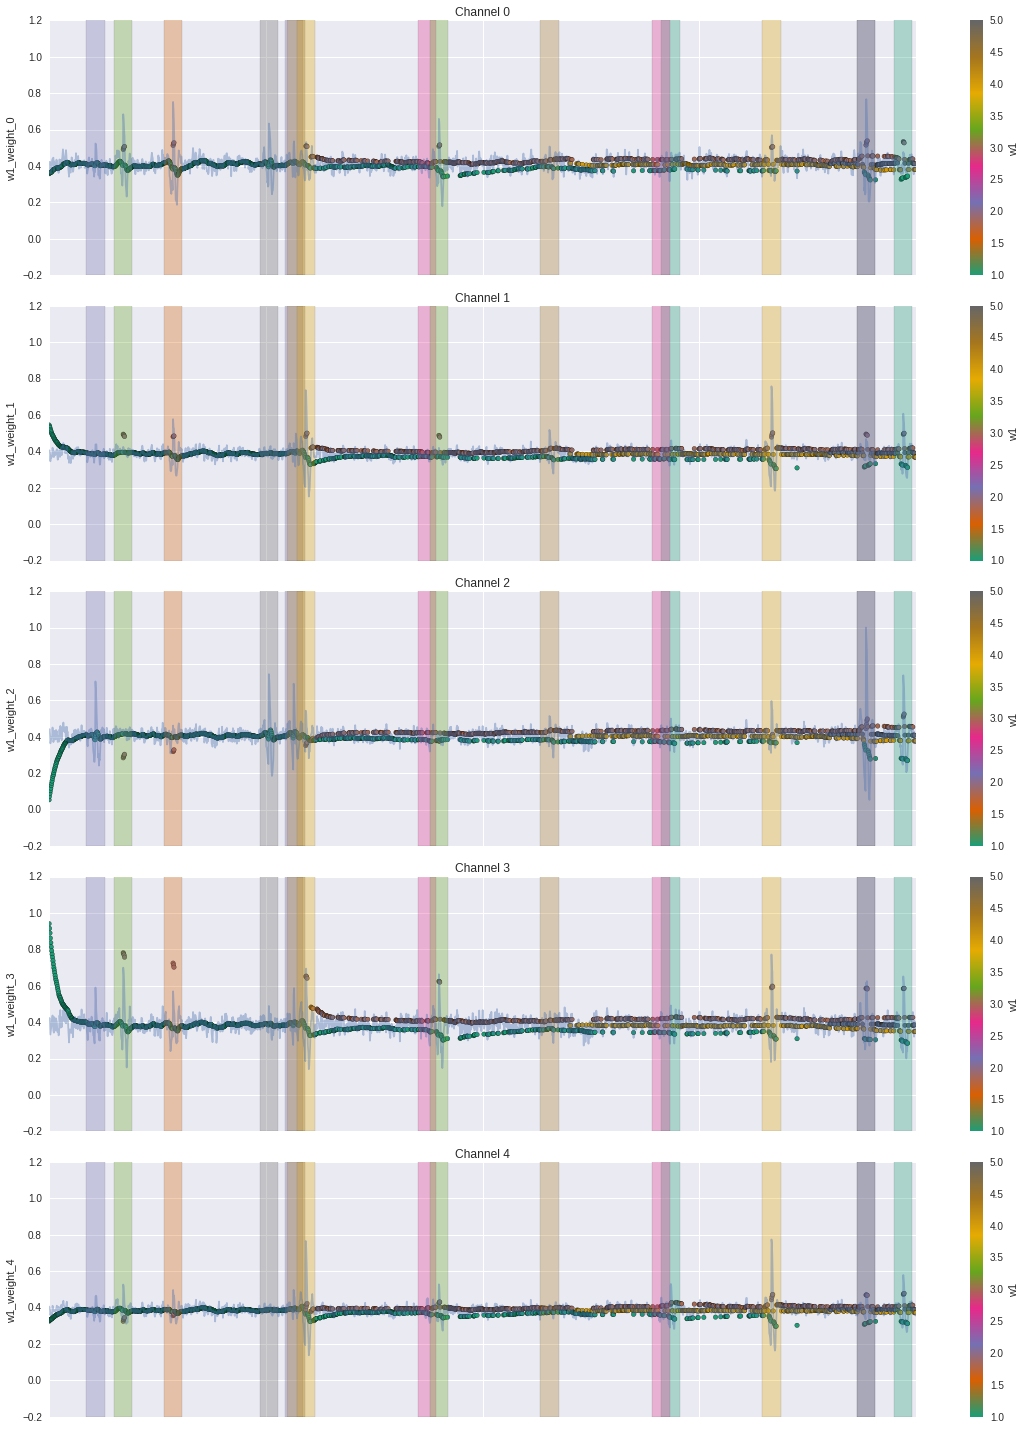

In [71]:
f, axes = plt.subplots(channels_nr, 1, figsize=(16, 4*channels_nr), sharex=True, sharey=True)
axes = axes.flatten()

marker_size = 100
cmap = sns.color_palette('Dark2', n_colors=neuron_nr)

from_idx = 0
to_idx = 2000
for i in range(channels_nr):
    ax = axes[i]
    winner_units.iloc[from_idx:to_idx, :].plot(kind='scatter', x='index',
                                               y='w1_weight_{}'.format(i),
                                               alpha=1, c='w1', ax=ax,
                                               cmap='Dark2')
    data.iloc[from_idx:to_idx, i].plot(alpha=0.4, ax=ax)
    for _, firing in firings[(from_idx <= firings.fire_idx)& (firings.fire_idx <= to_idx)].iterrows():
        ax.axvspan(firing.fire_idx, firing.fire_idx + window_size,
                   facecolor=cmap[firing.neuron], alpha=0.3)
    ax.set_title("Channel {}".format(i))
f.tight_layout()

In [79]:
unit_encoder = OneHotEncoder(sparse=False)
unit_encodings = unit_encoder.fit_transform(winner_units.w1.as_matrix()[:, np.newaxis])
spike_encodings = _get_spike_encodings(firings, unit_encodings,
                                       window_size)
pd.pivot_table(spike_encodings, index=['neuron', 'fire_idx'])

0         1         2         3         4         5   \
neuron fire_idx                                                               
0      1412      0.000000  0.309524  0.000000  0.500000  0.190476  0.000000   
       4676      0.000000  0.023810  0.000000  0.142857  0.000000  0.190476   
       6043      0.000000  0.000000  0.023810  0.119048  0.071429  0.095238   
       7668      0.000000  0.000000  0.000000  0.047619  0.261905  0.071429   
       9478      0.000000  0.261905  0.119048  0.071429  0.047619  0.023810   
       11347     0.000000  0.000000  0.000000  0.047619  0.095238  0.023810   
       11430     0.000000  0.000000  0.000000  0.000000  0.142857  0.047619   
       12596     0.000000  0.000000  0.000000  0.000000  0.095238  0.047619   
       13984     0.000000  0.000000  0.000000  0.095238  0.000000  0.047619   
       15953     0.000000  0.000000  0.000000  0.071429  0.071429  0.023810   
       18061     0.000000  0.000000  0.000000  0.000000  0.023810  0.047619   
       18370     0.000000  0.000000  0.000000  0.047619  0.000000  0.047619   
       19796     0.000000  0.000000  0.000000  0.071429  0.071429  0.000000   
       20319     0.000000  0.095238  0.071429  0.023810  0.000000  0.047619   
       27604     0.000000  0.000000  0.000000  0.000000  0.000000  0.023810   
       27781     0.000000  0.000000  0.000000  0.000000  0.071429  0.071429   
       32140     0.000000  0.000000  0.000000  0.000000  0.023810  0.023810   
       33881     0.000000  0.000000  0.000000  0.047619  0.000000  0.000000   
       35781     0.000000  0.119048  0.023810  0.000000  0.023810  0.047619   
       36654     0.000000  0.000000  0.000000  0.023810  0.000000  0.023810   
       37580     0.000000  0.000000  0.000000  0.023810  0.000000  0.000000   
       37913     0.000000  0.000000  0.000000  0.023810  0.000000  0.023810   
       38464     0.000000  0.047619  0.023810  0.071429  0.166667  0.000000   
       39628     0.000000  0.000000  0.000000  0.047619  0.000000  0.000000   
       40600     0.000000  0.000000  0.000000  0.071429  0.000000  0.047619   
       41036     0.000000  0.000000  0.000000  0.000000  0.000000  0.023810   
       41352     0.000000  0.000000  0.000000  0.000000  0.000000  0.095238   
       42034     0.000000  0.000000  0.000000  0.000000  0.047619  0.023810   
       44037     0.000000  0.000000  0.000000  0.071429  0.000000  0.000000   
       44640     0.000000  0.000000  0.000000  0.095238  0.000000  0.023810   
...                   ...       ...       ...       ...       ...       ...   
8      1947522   0.071429  0.166667  0.000000  0.023810  0.047619  0.000000   
       1951065   0.095238  0.214286  0.071429  0.047619  0.047619  0.000000   
       1954270   0.095238  0.238095  0.000000  0.071429  0.000000  0.000000   
       1954978   0.095238  0.238095  0.000000  0.166667  0.000000  0.023810   
       1955713   0.071429  0.142857  0.000000  0.238095  0.023810  0.000000   
       1957662   0.071429  0.214286  0.000000  0.142857  0.023810  0.000000   
       1957813   0.071429  0.214286  0.000000  0.023810  0.000000  0.000000   
       1959900   0.071429  0.190476  0.000000  0.000000  0.000000  0.000000   
       1963411   0.071429  0.214286  0.000000  0.000000  0.000000  0.000000   
       1964400   0.071429  0.261905  0.000000  0.047619  0.000000  0.000000   
       1967885   0.071429  0.047619  0.000000  0.023810  0.047619  0.000000   
       1969743   0.071429  0.190476  0.000000  0.023810  0.000000  0.023810   
       1971451   0.071429  0.190476  0.000000  0.023810  0.000000  0.000000   
       1973608   0.071429  0.190476  0.000000  0.047619  0.000000  0.000000   
       1982139   0.071429  0.238095  0.000000  0.023810  0.000000  0.023810   
       1982143   0.071429  0.238095  0.000000  0.023810  0.000000  0.023810   
       1984543   0.071429  0.214286  0.000000  0.095238  0.000000  0.000000   
       1987914   0.071429  0.238095  0.000000  0.095238  0.000000  0.0000

In [80]:
spike_encoding_mean_corr = spike_encodings.groupby('neuron').apply(
    _get_encoding_mean_corr
)
spike_encoding_mean_corr

,1412,4676,6043,7668,9478,11347,11430,12596,13984,15953,...,1980385,1981603,1982323,1982647,1983608,1984294,1985693,1995164,1996072,1997326
1412,1.000000,0.211740,0.234880,0.209806,0.521483,0.064886,-0.050212,-0.119908,0.103053,0.110849,...,0.429246,0.227221,0.316669,-0.052157,0.199469,0.139295,0.468555,-0.175742,0.162091,0.505162
4676,0.211740,1.000000,0.664085,0.091893,0.110027,0.306461,-0.013592,0.379340,0.585829,0.480115,...,0.084276,0.089468,0.062762,-0.170864,0.274893,0.199312,0.141736,0.220501,0.123233,0.185223
6043,0.234880,0.664085,1.000000,0.571366,0.014470,0.616838,0.164602,0.609673,0.254209,0.122985,...,0.244352,0.143754,0.128037,-0.070966,0.241728,0.366367,0.106803,-0.132065,0.203499,0.273533
7668,0.209806,0.091893,0.571366,1.000000,0.024329,0.512298,0.591664,0.634272,-0.057824,0.001425,...,0.029929,0.073110,0.070050,-0.070513,0.032873,0.012025,0.058432,-0.259591,0.252162,0.377584
9478,0.521483,0.110027,0.014470,0.024329,1.000000,0.010070,0.001828,-0.112580,0.146308,0.101999,...,-0.052545,-0.114084,-0.127836,0.140761,0.027159,-0.215148,0.356995,0.020107,-0.201125,-0.100045
11347,0.064886,0.306461,0.616838,0.512298,0.010070,1.000000,0.539673,0.672103,0.098803,0.187880,...,0.094972,0.170493,0.027226,-0.078934,0.047622,0.119035,-0.039228,0.051281,0.063399,0.150981
11430,-0.050212,-0.013592,0.164602,0.591664,0.001828,0.539673,1.000000,0.604025,0.107608,0.080950,...,-0.188883,-0.025321,-0.091653,-0.060684,-0.244511,-0.249800,-0.267584,0.202128,0.101930,0.177914
12596,-0.119908,0.379340,0.609673,0.634272,-0.112580,0.672103,0.604025,1.000000,0.227374,0.088721,...,-0.138492,0.097470,0.054477,-0.034066,0.026145,0.063902,-0.095213,0.002559,0.272125,0.106360
13984,0.103053,0.585829,0.254209,-0.057824,0.146308,0.098803,0.107608,0.227374,1.000000,0.743664,...,0.110758,0.188073,0.168345,-0.153456,0.490961,0.183563,0.130537,0.680739,0.161958,0.192055
15953,0.110849,0.480115,0.122985,0.001425,0.101999,0.187880,0.080950,0.088721,0.743664,1.000000,...,-0.017110,0.085633,-0.043303,-0.115439,0.398839,0.136344,0.106464,0.530671,0.072279,0.389729


,1412,4676,6043,7668,9478,11347,11430,12596,13984,15953,...,1980385,1981603,1982323,1982647,1983608,1984294,1985693,1995164,1996072,1997326
1412,1.000000,0.211740,0.234880,0.209806,0.521483,0.064886,-0.050212,-0.119908,0.103053,0.110849,...,0.429246,0.227221,0.316669,-0.052157,0.199469,0.139295,0.468555,-0.175742,0.162091,0.505162
4676,0.211740,1.000000,0.664085,0.091893,0.110027,0.306461,-0.013592,0.379340,0.585829,0.480115,...,0.084276,0.089468,0.062762,-0.170864,0.274893,0.199312,0.141736,0.220501,0.123233,0.185223
6043,0.234880,0.664085,1.000000,0.571366,0.014470,0.616838,0.164602,0.609673,0.254209,0.122985,...,0.244352,0.143754,0.128037,-0.070966,0.241728,0.366367,0.106803,-0.132065,0.203499,0.273533
7668,0.209806,0.091893,0.571366,1.000000,0.024329,0.512298,0.591664,0.634272,-0.057824,0.001425,...,0.029929,0.073110,0.070050,-0.070513,0.032873,0.012025,0.058432,-0.259591,0.252162,0.377584
9478,0.521483,0.110027,0.014470,0.024329,1.000000,0.010070,0.001828,-0.112580,0.146308,0.101999,...,-0.052545,-0.114084,-0.127836,0.140761,0.027159,-0.215148,0.356995,0.020107,-0.201125,-0.100045
11347,0.064886,0.306461,0.616838,0.512298,0.010070,1.000000,0.539673,0.672103,0.098803,0.187880,...,0.094972,0.170493,0.027226,-0.078934,0.047622,0.119035,-0.039228,0.051281,0.063399,0.150981
11430,-0.050212,-0.013592,0.164602,0.591664,0.001828,0.539673,1.000000,0.604025,0.107608,0.080950,...,-0.188883,-0.025321,-0.091653,-0.060684,-0.244511,-0.249800,-0.267584,0.202128,0.101930,0.177914
12596,-0.119908,0.379340,0.609673,0.634272,-0.112580,0.672103,0.604025,1.000000,0.227374,0.088721,...,-0.138492,0.097470,0.054477,-0.034066,0.026145,0.063902,-0.095213,0.002559,0.272125,0.106360
13984,0.103053,0.585829,0.254209,-0.057824,0.146308,0.098803,0.107608,0.227374,1.000000,0.743664,...,0.110758,0.188073,0.168345,-0.153456,0.490961,0.183563,0.130537,0.680739,0.161958,0.192055
15953,0.110849,0.480115,0.122985,0.001425,0.101999,0.187880,0.080950,0.088721,0.743664,1.000000,...,-0.017110,0.085633,-0.043303,-0.115439,0.398839,0.136344,0.106464,0.530671,0.072279,0.389729


,265,5824,8836,10276,11786,11845,13818,16160,16743,17125,...,1977146,1977704,1977873,1985119,1986972,1988307,1991311,1992021,1993636,1999083
265,1.000000,0.309918,0.372142,-0.097535,-0.135506,0.056504,0.332840,-0.147414,0.177222,0.088381,...,0.194426,0.202034,0.088125,0.082613,0.171937,0.082506,-0.095405,-0.103726,-0.017489,-0.113351
5824,0.309918,1.000000,0.763330,0.333337,0.307850,0.219676,0.326739,0.308603,0.331128,0.267690,...,0.065414,0.209585,-0.086920,0.103032,-0.057531,0.200955,-0.022860,0.075852,0.276003,0.072904
8836,0.372142,0.763330,1.000000,0.445123,0.408727,0.261786,0.490256,0.420911,0.377053,0.419205,...,0.009839,0.172100,0.105655,-0.014943,0.154426,0.196338,-0.042346,0.095296,0.210954,0.059341
10276,-0.097535,0.333337,0.445123,1.000000,0.866674,0.744273,0.444304,0.484291,0.407245,0.579763,...,0.010004,0.045047,-0.071619,-0.040518,-0.012182,-0.021335,0.028705,0.144661,0.130506,0.171831
11786,-0.135506,0.307850,0.408727,0.866674,1.000000,0.645100,0.475700,0.465934,0.262651,0.546700,...,-0.030587,-0.077190,-0.093848,0.002212,-0.007095,-0.007988,-0.020253,0.126969,0.111750,0.156410
11845,0.056504,0.219676,0.261786,0.744273,0.645100,1.000000,0.363916,0.324187,0.329638,0.374255,...,-0.045812,-0.067439,-0.137897,0.001933,0.009298,-0.033148,-0.055613,0.087494,0.105030,0.069077
13818,0.332840,0.326739,0.490256,0.444304,0.475700,0.363916,1.000000,0.671984,0.702593,0.667630,...,-0.064034,-0.149714,-0.244841,-0.051330,-0.041155,-0.070720,-0.325068,-0.238041,-0.121995,0.044079
16160,-0.147414,0.308603,0.420911,0.484291,0.465934,0.324187,0.671984,1.000000,0.739277,0.671984,...,0.049913,-0.108671,-0.148502,-0.021660,-0.142790,0.023896,-0.147938,-0.173145,0.066311,0.188854
16743,0.177222,0.331128,0.377053,0.407245,0.262651,0.329638,0.702593,0.739277,1.000000,0.486214,...,-0.009400,-0.083027,-0.250066,-0.080903,-0.112563,-0.062289,-0.278535,-0.267369,-0.052815,0.066555
17125,0.088381,0.267690,0.419205,0.579763,0.546700,0.374255,0.667630,0.671984,0.486214,1.000000,...,0.002668,-0.163576,-0.244841,-0.199915,-0.149459,-0.180458,-0.316235,-0.248961,-0.121995,-0.113345


,86,543,1863,8305,10016,10427,11721,12871,13370,23279,...,1969177,1969184,1977574,1980132,1990188,1991113,1991122,1994500,1995773,1999957
86,1.000000,1.000000,0.449186,-0.103521,-0.149105,-0.123378,-0.149105,-0.162062,0.637120,-0.112854,...,0.204702,0.223113,-0.144430,-0.111463,-0.150767,0.215171,0.215171,-0.147496,-0.133834,0.065351
543,1.000000,1.000000,0.449186,-0.103521,-0.149105,-0.123378,-0.149105,-0.162062,0.637120,-0.112854,...,0.204702,0.223113,-0.144430,-0.111463,-0.150767,0.215171,0.215171,-0.147496,-0.133834,0.065351
1863,0.449186,0.449186,1.000000,0.422622,0.205415,0.103229,0.146264,0.305090,0.783886,0.008954,...,0.156323,0.170383,0.100008,0.089240,0.555692,0.225427,0.300117,0.059577,-0.023168,0.364054
8305,-0.103521,-0.103521,0.422622,1.000000,0.526803,0.480001,0.229905,0.713244,0.210925,0.053010,...,0.221308,0.251179,0.451292,0.592990,0.594257,0.386427,0.415265,0.310262,0.062864,0.032699
10016,-0.149105,-0.149105,0.205415,0.526803,1.000000,0.718581,0.660088,0.562517,0.321064,0.375119,...,-0.063224,0.017228,0.288894,0.395084,0.434617,0.058151,0.141223,0.295028,0.307068,0.271369
10427,-0.123378,-0.123378,0.103229,0.480001,0.718581,1.000000,0.609705,0.583796,0.144260,0.612550,...,-0.063215,-0.033262,0.230259,0.448999,0.350452,-0.077904,-0.020622,0.073596,0.066779,0.196710
11721,-0.149105,-0.149105,0.146264,0.229905,0.660088,0.609705,1.000000,0.538682,0.122557,0.698784,...,0.160696,0.203861,0.384484,0.403281,0.401355,0.099687,0.224295,0.186562,0.061020,0.125592
12871,-0.162062,-0.162062,0.305090,0.713244,0.562517,0.583796,0.538682,1.000000,0.198872,0.416737,...,0.260558,0.252785,0.498703,0.607597,0.496485,0.273883,0.439416,0.167406,-0.008558,-0.021938
13370,0.637120,0.637120,0.783886,0.210925,0.321064,0.144260,0.122557,0.198872,1.000000,-0.037888,...,0.105752,0.137864,-0.015048,0.046454,0.237374,0.045772,0.154752,0.138310,0.133245,0.416610
23279,-0.112854,-0.112854,0.008954,0.053010,0.375119,0.612550,0.698784,0.416737,-0.037888,1.000000,...,-0.097700,0.078236,0.033763,0.255603,0.203077,-0.029342,-0.008383,0.075528,-0.110247,0.179931


,850,1390,2156,3292,5531,7131,9165,11026,11434,11878,...,1974167,1976204,1976571,1991297,1991571,1992317,1992939,1994940,1995328,1997374
850,1.000000,0.875974,0.850265,0.430142,0.537067,0.061615,0.075537,0.079780,-0.242876,-0.203720,...,0.497504,-0.160714,-0.078811,0.081130,0.112272,0.014848,-0.142731,-0.168408,0.114153,0.082551
1390,0.875974,1.000000,0.884323,0.543811,0.616733,0.372750,-0.024820,-0.026214,0.036213,-0.248063,...,0.270792,-0.237113,-0.187361,-0.026658,-0.036890,-0.085233,-0.210582,-0.248465,0.083841,0.148387
2156,0.850265,0.884323,1.000000,0.741903,0.760426,0.323774,-0.012601,0.086508,0.026046,-0.233036,...,0.465832,-0.241291,-0.216928,0.029968,-0.018729,-0.089168,-0.163270,-0.112375,0.218993,0.227224
3292,0.430142,0.543811,0.741903,1.000000,0.632780,0.689082,0.158848,0.167772,0.225110,-0.171085,...,0.501628,-0.177946,-0.069212,0.054285,0.283050,-0.014902,-0.061395,-0.032195,0.383268,0.420188
5531,0.537067,0.616733,0.760426,0.632780,1.000000,0.459921,0.021950,0.218791,0.049152,-0.212480,...,0.150397,-0.396962,-0.126674,0.089881,0.063211,-0.249167,-0.024194,0.032625,0.178296,0.151427
7131,0.061615,0.372750,0.323774,0.689082,0.459921,1.000000,0.212370,0.109601,0.450606,-0.068340,...,0.001538,-0.280690,-0.054764,0.085536,0.172172,-0.048385,0.085121,-0.150651,0.238879,0.298025
9165,0.075537,-0.024820,-0.012601,0.158848,0.021950,0.212370,1.000000,0.314041,0.175307,0.206889,...,0.350746,0.012589,0.233826,0.001589,0.211075,0.429184,0.029815,0.112134,0.181078,-0.006467
11026,0.079780,-0.026214,0.086508,0.167772,0.218791,0.109601,0.314041,1.000000,0.357394,0.381040,...,0.310700,-0.186154,0.136930,0.068802,-0.078955,0.158469,-0.047236,0.698988,0.557224,-0.109279
11434,-0.242876,0.036213,0.026046,0.225110,0.049152,0.450606,0.175307,0.357394,1.000000,0.520705,...,-0.114335,-0.185048,-0.060614,-0.074440,-0.360546,0.038466,0.002568,0.396904,0.326539,-0.020050
11878,-0.203720,-0.248063,-0.233036,-0.171085,-0.212480,-0.068340,0.206889,0.381040,0.520705,1.000000,...,-0.085005,-0.227973,0.042814,-0.145078,-0.099113,0.314580,-0.008615,0.447277,0.338493,-0.203677


,150,878,4778,6909,6914,8378,10970,16105,17432,17883,...,1978978,1982639,1983692,1989920,1990598,1992945,1995504,1997051,1998288,1999229
150,1.000000,0.750398,0.542649,0.433586,0.433586,-0.112639,-0.148962,-0.197043,-0.146986,-0.160498,...,-0.090620,0.095159,-0.096222,-0.100112,0.481191,-0.132377,-0.128479,-0.080645,-0.073681,0.527304
878,0.750398,1.000000,0.774987,0.558944,0.620592,-0.046490,0.110634,-0.099651,-0.006758,-0.007379,...,0.021338,0.046527,-0.147270,0.231859,0.751583,-0.125902,-0.121009,-0.127425,-0.120914,0.396489
4778,0.542649,0.774987,1.000000,0.631513,0.669329,0.174822,0.190539,-0.109286,0.035925,0.016596,...,0.028359,-0.048685,-0.160983,0.120956,0.514376,-0.166114,-0.207217,-0.122063,-0.102527,0.365398
6909,0.433586,0.558944,0.631513,1.000000,0.958054,0.339980,0.184139,-0.231766,0.029428,-0.138573,...,0.161155,0.214525,0.040082,0.178696,0.593635,0.050429,-0.059694,0.179580,0.103081,0.494199
6914,0.433586,0.620592,0.669329,0.958054,1.000000,0.356484,0.236254,-0.157798,-0.025749,-0.068282,...,0.095822,0.181006,-0.052415,0.205235,0.602739,-0.065946,-0.142029,0.065561,0.059526,0.408183
8378,-0.112639,-0.046490,0.174822,0.339980,0.356484,1.000000,0.488695,0.402590,0.598821,0.377308,...,-0.141380,-0.052753,-0.165285,-0.059171,-0.069855,-0.103023,-0.240940,0.036450,0.079973,-0.006153
10970,-0.148962,0.110634,0.190539,0.184139,0.236254,0.488695,1.000000,0.564157,0.411316,0.563489,...,0.091693,0.037018,-0.022345,0.047627,0.162138,-0.008033,-0.115082,0.067878,-0.058623,0.025907
16105,-0.197043,-0.099651,-0.109286,-0.231766,-0.157798,0.402590,0.564157,1.000000,0.462169,0.430875,...,-0.211215,-0.325096,-0.156312,-0.153396,-0.184637,-0.353427,-0.284332,-0.217815,-0.243217,-0.342428
17432,-0.146986,-0.006758,0.035925,0.029428,-0.025749,0.598821,0.411316,0.462169,1.000000,0.442495,...,-0.237131,-0.193516,-0.057456,-0.095033,-0.127751,0.012757,-0.099281,-0.045307,-0.157557,-0.212578
17883,-0.160498,-0.007379,0.016596,-0.138573,-0.068282,0.377308,0.563489,0.430875,0.442495,1.000000,...,-0.206797,-0.117689,-0.099643,-0.177889,-0.226679,0.002322,-0.367106,-0.117710,-0.180730,-0.232120


,571,1645,2068,5619,6967,7483,7802,8779,8817,9464,...,1980814,1981361,1981380,1986448,1988385,1990321,1991257,1992985,1993902,1996215
571,1.000000,0.788438,0.728510,0.792341,0.788558,0.695072,0.723630,0.692697,0.584176,0.764611,...,0.770160,0.529743,0.634979,0.829629,0.595651,0.710583,0.692647,0.784936,0.759771,0.726025
1645,0.788438,1.000000,0.934245,0.835428,0.761984,0.770359,0.631880,0.473961,0.632849,0.705285,...,0.583991,0.807322,0.829219,0.718275,0.410689,0.733168,0.790442,0.709874,0.838665,0.920753
2068,0.728510,0.934245,1.000000,0.815687,0.745566,0.784475,0.693576,0.495967,0.641785,0.812968,...,0.568706,0.756235,0.772916,0.699800,0.345030,0.663349,0.751796,0.629250,0.797789,0.852485
5619,0.792341,0.835428,0.815687,1.000000,0.941937,0.783731,0.711179,0.685896,0.676897,0.747553,...,0.606647,0.673002,0.712476,0.697416,0.394800,0.711877,0.767487,0.647180,0.819626,0.789676
6967,0.788558,0.761984,0.745566,0.941937,1.000000,0.821568,0.779917,0.798980,0.679304,0.770873,...,0.563237,0.530074,0.612108,0.658177,0.388177,0.617093,0.643171,0.586708,0.737638,0.725050
7483,0.695072,0.770359,0.784475,0.783731,0.821568,1.000000,0.907018,0.714971,0.661410,0.838966,...,0.648723,0.566647,0.732633,0.648539,0.389650,0.537700,0.614966,0.568539,0.729361,0.723343
7802,0.723630,0.631880,0.693576,0.711179,0.779917,0.907018,1.000000,0.787646,0.687734,0.906757,...,0.684713,0.336965,0.539283,0.604728,0.400757,0.411953,0.472695,0.514399,0.604422,0.531306
8779,0.692697,0.473961,0.495967,0.685896,0.798980,0.714971,0.787646,1.000000,0.734770,0.770425,...,0.551955,0.268217,0.433853,0.477047,0.297049,0.412254,0.388096,0.424684,0.496061,0.399872
8817,0.584176,0.632849,0.641785,0.676897,0.679304,0.661410,0.687734,0.734770,1.000000,0.786910,...,0.409116,0.365290,0.501701,0.380709,0.162784,0.356854,0.384731,0.361072,0.450965,0.550271
9464,0.764611,0.705285,0.812968,0.747553,0.770873,0.838966,0.906757,0.770425,0.786910,1.000000,...,0.618431,0.372791,0.516402,0.628776,0.342902,0.442380,0.489969,0.497323,0.596006,0.601566


,548,1133,4497,5510,5618,7398,9357,9612,10516,13471,...,1972495,1972744,1974497,1981428,1982121,1984052,1990704,1991616,1992822,1994544
548,1.000000,0.582130,0.042192,-0.100889,0.712131,-0.104633,-0.144430,-0.135032,-0.138830,-0.191655,...,-0.176346,-0.171174,-0.138830,-0.164203,0.195627,0.215171,-0.166431,-0.154266,-0.168752,-0.188275
1133,0.582130,1.000000,0.574972,0.090876,0.795275,0.580690,0.046163,0.121630,0.044373,-0.050119,...,-0.046116,0.054711,-0.116983,-0.042940,0.079579,0.196941,0.053195,0.318251,-0.240263,0.169588
4497,0.042192,0.574972,1.000000,0.534930,0.489561,0.778319,0.527356,0.558607,0.412537,0.057695,...,-0.135286,-0.006649,-0.119986,-0.062188,-0.081450,0.157235,0.017778,0.241188,-0.211397,0.001828
5510,-0.100889,0.090876,0.534930,1.000000,0.408098,0.506059,0.468565,0.330574,0.415857,0.135417,...,-0.191288,0.027255,-0.150593,-0.120923,0.078359,0.217343,-0.056313,0.170407,-0.216638,-0.129282
5618,0.712131,0.795275,0.489561,0.408098,1.000000,0.457218,0.128635,0.095210,0.136528,-0.060455,...,-0.235592,-0.006352,-0.224111,-0.249837,0.073051,0.150218,-0.106541,0.173176,-0.342868,-0.085590
7398,-0.104633,0.580690,0.778319,0.506059,0.457218,1.000000,0.530672,0.405555,0.381139,0.278907,...,-0.052782,0.160767,0.001433,0.010168,-0.077734,0.099102,0.164902,0.511087,-0.102759,0.254556
9357,-0.144430,0.046163,0.527356,0.468565,0.128635,0.530672,1.000000,0.675230,0.694218,0.262119,...,0.027635,0.026825,0.110758,0.084215,-0.046334,0.163617,0.215766,0.309882,0.266858,0.056327
9612,-0.135032,0.121630,0.558607,0.330574,0.095210,0.405555,0.675230,1.000000,0.649048,0.423756,...,0.237233,-0.214315,0.214500,0.177155,0.093478,0.278357,0.168475,0.207529,0.227017,0.115355
10516,-0.138830,0.044373,0.412537,0.415857,0.136528,0.381139,0.694218,0.649048,1.000000,0.461918,...,0.123160,-0.103139,0.020913,-0.053967,-0.103139,0.337750,0.127631,0.181677,0.395165,0.079926
13471,-0.191655,-0.050119,0.057695,0.135417,-0.060455,0.278907,0.262119,0.423756,0.461918,1.000000,...,0.236698,0.051776,0.304446,0.329047,0.181216,0.252709,0.254853,0.323716,0.242457,0.306098


,486,1863,4163,4544,8557,11299,15531,16672,20421,23967,...,1987449,1988500,1989986,1990627,1995050,1996031,1996174,1996531,1996757,1998734
486,1.000000,0.449186,-0.086466,-0.026528,-0.115043,-0.162062,-0.117364,-0.149105,-0.182018,-0.137528,...,-0.127259,-0.112152,-0.131530,0.745395,-0.176346,-0.118992,-0.131530,-0.124315,0.430311,-0.110121
1863,0.449186,1.000000,0.586868,0.529729,0.602425,0.118062,0.474903,0.243056,0.060392,0.030751,...,0.280876,0.198998,0.147998,0.494224,-0.087765,-0.149339,0.048384,-0.245685,0.171483,-0.054806
4163,-0.086466,0.586868,1.000000,0.903550,0.624041,0.222537,0.696691,0.376426,-0.060544,-0.022286,...,0.554631,0.522270,0.483502,0.185565,0.129348,-0.100473,0.029167,-0.163282,-0.122948,-0.111767
4544,-0.026528,0.529729,0.903550,1.000000,0.501521,0.290910,0.629876,0.308619,0.035007,0.039046,...,0.449880,0.478646,0.440888,0.203769,0.050067,-0.173275,-0.040957,-0.220875,-0.087687,-0.170443
8557,-0.115043,0.602425,0.624041,0.501521,1.000000,0.369648,0.580675,0.247034,0.218943,0.009364,...,0.593527,0.497617,0.389563,0.096077,0.442251,0.244404,0.389563,0.128373,0.208752,0.269921
11299,-0.162062,0.118062,0.222537,0.290910,0.369648,1.000000,0.048780,0.419504,0.483007,0.463881,...,0.174951,0.100398,0.138772,0.025180,0.439767,0.296739,0.359545,0.240458,0.276873,0.204203
15531,-0.117364,0.474903,0.696691,0.629876,0.580675,0.048780,1.000000,0.398741,-0.008429,0.017513,...,0.649699,0.579066,0.557306,0.172097,-0.069411,-0.115713,-0.082225,-0.128085,-0.104614,-0.062467
16672,-0.149105,0.243056,0.376426,0.308619,0.247034,0.419504,0.398741,1.000000,0.497932,0.548156,...,0.160964,0.141856,0.098660,-0.049230,-0.049279,-0.015751,0.166367,0.010970,0.041138,0.106895
20421,-0.182018,0.060392,-0.060544,0.035007,0.218943,0.483007,-0.008429,0.497932,1.000000,0.595078,...,-0.169077,-0.098666,-0.233790,-0.289879,0.177304,0.194412,0.427434,0.281228,0.233707,0.308433
23967,-0.137528,0.030751,-0.022286,0.039046,0.009364,0.463881,0.017513,0.548156,0.595078,1.000000,...,-0.084591,-0.188656,-0.185568,-0.239059,-0.177027,-0.014528,-0.007137,-0.057338,0.067131,-0.110547


,1949,2152,5537,5925,8069,9418,9719,10623,10696,16069,...,1990602,1990640,1993934,1994011,1994058,1996417,1996739,1996909,1997832,1999204
1949,1.000000,0.993134,0.781702,0.763213,0.592117,0.329872,0.301520,0.291642,0.671107,0.575137,...,0.711172,0.376870,0.670215,0.332665,0.603000,0.861333,0.462014,0.708539,0.393623,0.391266
2152,0.993134,1.000000,0.795567,0.767124,0.624736,0.367223,0.320395,0.323622,0.670605,0.588547,...,0.671514,0.423617,0.624033,0.316283,0.588831,0.827478,0.465832,0.720380,0.405504,0.417760
5537,0.781702,0.795567,1.000000,0.923274,0.730051,0.398177,0.385584,0.424239,0.732934,0.568942,...,0.520183,0.329877,0.427184,0.134982,0.381126,0.635424,0.229274,0.567997,0.260302,0.380165
5925,0.763213,0.767124,0.923274,1.000000,0.740319,0.547470,0.498700,0.535501,0.743243,0.607743,...,0.572052,0.416107,0.556521,0.272071,0.528700,0.737120,0.380118,0.641625,0.409530,0.441384
8069,0.592117,0.624736,0.730051,0.740319,1.000000,0.695538,0.695325,0.728108,0.644611,0.491630,...,0.587310,0.404383,0.309597,0.415516,0.465236,0.423517,0.382450,0.445743,0.277348,0.343447
9418,0.329872,0.367223,0.398177,0.547470,0.695538,1.000000,0.690804,0.833189,0.442848,0.283274,...,0.381463,0.270383,0.197054,0.156005,0.349647,0.227097,0.207785,0.259699,0.228403,0.221052
9719,0.301520,0.320395,0.385584,0.498700,0.695325,0.690804,1.000000,0.899102,0.527300,0.326621,...,0.544062,0.415146,0.236224,0.308361,0.344439,0.326948,0.347500,0.385814,0.376868,0.344738
10623,0.291642,0.323622,0.424239,0.535501,0.728108,0.833189,0.899102,1.000000,0.607509,0.296539,...,0.484491,0.384132,0.222653,0.235095,0.383788,0.264000,0.295899,0.315427,0.300934,0.357488
10696,0.671107,0.670605,0.732934,0.743243,0.644611,0.442848,0.527300,0.607509,1.000000,0.425984,...,0.576147,0.467020,0.529452,0.401667,0.583037,0.624062,0.410715,0.563582,0.392914,0.472679
16069,0.575137,0.588547,0.568942,0.607743,0.491630,0.283274,0.326621,0.296539,0.425984,1.000000,...,0.351319,0.356775,0.326257,0.137176,0.269202,0.485841,0.323645,0.608944,0.340425,0.184248


neuron
0    0.042601
1    0.222048
2    0.103320
3    0.051601
4    0.196120
5    0.513203
6    0.059191
7    0.118582
8    0.358008
dtype: float64

In [81]:
mean_neuron_encodings = spike_encodings.groupby('neuron').apply(
    lambda g: g.iloc[:, 2:].mean()
)
neuron_encoding_error = _get_encoding_mean_corr(mean_neuron_encodings)
neuron_encoding_error

neuron,0,1,2,3,4,5,6,7,8
neuron,,,,,,,,,
0,1.000000,0.241958,0.732804,0.696284,0.208054,0.569614,0.943745,0.658388,0.711611
1,0.241958,1.000000,0.584884,-0.412417,0.988187,0.434840,0.261273,0.543616,0.467057
2,0.732804,0.584884,1.000000,0.211224,0.571480,0.577688,0.786618,0.978635,0.771000
3,0.696284,-0.412417,0.211224,1.000000,-0.436986,0.271296,0.596953,0.158267,0.349956
4,0.208054,0.988187,0.571480,-0.436986,1.000000,0.370695,0.231684,0.535505,0.421007
5,0.569614,0.434840,0.577688,0.271296,0.370695,1.000000,0.641055,0.492836,0.939716
6,0.943745,0.261273,0.786618,0.596953,0.231684,0.641055,1.000000,0.732525,0.749239
7,0.658388,0.543616,0.978635,0.158267,0.535505,0.492836,0.732525,1.000000,0.683199
8,0.711611,0.467057,0.771000,0.349956,0.421007,0.939716,0.749239,0.683199,1.000000


0.50731920660470364

In [78]:
def _get_spike_encodings(firings, unit_encodings, window_size):
    fire_ids = np.unique(firings.fire_idx)
    # noinspection PyTypeChecker
    indexes = np.array([np.arange(i, i + window_size) for i in fire_ids])
    encodings = unit_encodings[indexes].mean(axis=1)
    encodings = pd.DataFrame(encodings, index=fire_ids)
    return firings.join(encodings)


def _get_encoding_mean_corr(encoding):
    corr_matrix = encoding.iloc[:, 2:].T.corr()
    display(corr_matrix)
    corr_len = len(corr_matrix)
    corr_matrix = corr_matrix.as_matrix() - np.eye(corr_len)
    indexes = np.tril_indices(corr_len, -1)
    corr_matrix = corr_matrix[indexes]
    return corr_matrix.mean()


def scorer(window_size, firings, estimator):
    winner_units = estimator.winners
    unit_encoder = OneHotEncoder(sparse=False)
    unit_encodings = unit_encoder.fit_transform(winner_units[:, np.newaxis])
    spike_encodings = _get_spike_encodings(firings, unit_encodings,
                                           window_size)

    spike_encoding_mean_corr = spike_encodings.groupby('neuron').apply(
        _get_encoding_mean_corr
    )
    spike_encoding_error = spike_encoding_mean_corr.mean()

    mean_neuron_encodings = spike_encodings.groupby('neuron').apply(
        lambda g: g.iloc[:, 2:].mean()
    )
    neuron_encoding_error = _get_encoding_mean_corr(mean_neuron_encodings)

    ret_val = spike_encoding_error - np.abs(neuron_encoding_error)
    return ret_val, spike_encoding_error, neuron_encoding_error


In [39]:
_get_spike_encodings(firings[firings.fire_idx < 10000], unit_encodings, window_size)

NotImplementedError: Index._join_level on non-unique index is not implemented